<a href="https://colab.research.google.com/github/pearl629/word2vec/blob/main/hindi_english_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building** **a** **Neural** **Machine** **Translation** **Model** **from** **Scratch**
# : *Sequence*-*to*-*Sequence* *Model* *Training* *with* *Luong* *Attention* *Mechanism* :

 This script trains a sequence-to-sequence (Seq2Seq) model for translating Hindi to English. The model consists of an encoder and an attention-based decoder using the Luong attention mechanism. The script includes data loading, model definition, and training functions with performance tracking and plotting.

In [2]:
# Importing necessary libraries
import pandas as pd
import unicodedata
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader, RandomSampler
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import sacrebleu
import nltk
from nltk.translate.meteor_score import meteor_score
import random

In [3]:
MAX_LENGTH = 10  # Maximum length of sequences
hidden_size = 256  # Size of hidden state in RNN
batch_size = 816  # Batch size for training

In [4]:
# Sets the device to 'cuda' if a GPU is available, otherwise uses 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Preparing** **Data**:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#The data consists of a large parallel corpus of Hindi and English sentences.
df=pd.read_csv("/content/drive/MyDrive/HinEng/hindi_english_parallel.csv.zip")

Clean the sentences by removing special characters.

In [7]:
# Lowercase, trim, and remove non-letter characters
def unicodeToAscii(s):
    """Converts a Unicode string to ASCII by removing accents."""
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def normalizeString_for_eng(s):
    """Normalizes an English string for processing."""
    s = str(s)
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z0-9!?]+", r" ", s)
    return s.strip()

def normalizeString_for_hin(s):
    """Normalizes a Hindi string for processing."""
    s = str(s)
    hindi_chars = "\u0900-\u097F\u0980-\u09FF a-zA-Z0-9!? |"
    s = re.sub(r"[^" + hindi_chars + "]", r" ", s)
    return s.strip()
list_of_pairs = []
for index, row in df.iterrows():
    english_sentence =   normalizeString_for_eng(row["english"])
    hindi_sentence =  normalizeString_for_hin(row["hindi"])
    if len( english_sentence.split(' ')) < MAX_LENGTH and len(hindi_sentence.split(' '))< MAX_LENGTH:
      sentence_pair = [hindi_sentence, english_sentence]
      list_of_pairs.append(sentence_pair)

Split the  cleaned dataset into training, validation, and test sets

In [8]:
train_set, df_temp = train_test_split(list_of_pairs, test_size=0.2, random_state=42)
val_set, test_set = train_test_split(df_temp, test_size=0.2, random_state=42)

Preparing data by building vocabularies and creating index-to-word and word-to-index mappings for each language.

In [9]:
sos = 0  # Start-of-sentence token
eos= 1  # End-of-sentence token

class Tokenizer:
    def __init__(self, Language_name):#language_name (str): The name of the language.


        self.Language_name = Language_name
        self.Word_To_Index = {}  # Dictionary to map words to indices
        self.Index_To_Word = {}  # Dictionary to map indices to words
        self.Vocab_Len = 2  # Initial vocabulary size (including SOS and EOS tokens)
        self.Index_To_Word = {0: "sos", 1: "eos"}
    def build_vocabulary(self, Text):
        """
        Builds the vocabulary for the tokenizer based on the given text.

        Args:
            text (str): The text to build the vocabulary from.
        """
        for word in Text.split(" "):
            if word not in self.Word_To_Index:
                self.Word_To_Index[word] = self.Vocab_Len
                self.Index_To_Word[self.Vocab_Len] = word
                self.Vocab_Len += 1

In [10]:
def prepareData(lang1, lang2):
    """
     Args:
        lang1 (str): The name of the source language.(hindi).
        lang2 (str): The name of the target language.(english).
    Returns:
        input_lang (Tokenizer): Tokenizer instance for the source language.
        output_lang (Tokenizer): Tokenizer instance for the target language.
        pairs (list): List of parallel sentence pairs.
    """
    pairs = list_of_pairs
    input_lang = Tokenizer(lang1)
    output_lang = Tokenizer(lang2)
    for pair in pairs:
        input_lang.build_vocabulary(pair[0])
        output_lang.build_vocabulary(pair[1])
    return input_lang, output_lang, pairs

In [11]:
def indexesFromSentence(Tokenizer, Text):#Converts a sentence into a list of indices  .
    return [Tokenizer.Word_To_Index[word] for word in Text.split(" ")]

def tensorFromSentence(Tokenizer, Text):#Converts a sentence into a PyTorch tensor of indices.
    indexes = indexesFromSentence(Tokenizer, Text)
    indexes.append(eos)  # Append end-of-sentence token
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(lang1, lang2, pair):#Converts a pair of sentences into input and target tensors.
    input_tensor = tensorFromSentence(lang1, pair[0])
    target_tensor = tensorFromSentence(lang2, pair[1])
    return input_tensor, target_tensor

In [12]:
inp_instance,out_instance,pairs=prepareData('hin', 'eng')
print(indexesFromSentence(out_instance,"hi then yes and 0 "))

print(indexesFromSentence(inp_instance,"के 13"))

[3243, 4402, 751, 22, 67, 648]
[14, 4333]


# **The Seq2Seq Model**
***Model*** ***Overview***:

*The* *model* *is* *a* *sequenec*-*to*-*sequence* *architecture* *comprising*:

**1**.   **Bidirectional** **RNN** **Encoder**:



Encodes input sequences into context vectors by processing in both forward and backward directions.                                                                                                                                                     
                                                                      
                                                                       
                                                                        
                                                                         
                                                                          
                                                                           
**2**.   **Luong** **Attention** (Dot-Product):     



Computes alignment scores and context vectors using a dot-product attention mechanism to improve focus on relevant parts of the input sequence.                                                                      


**3**.   **RNN** **Decoder**:

Generates output sequences using the context vectors provided by the attention mechanism, predicting the next token based on the current hidden state and context.


BIDIRECTIONAL RNN ENCODER:

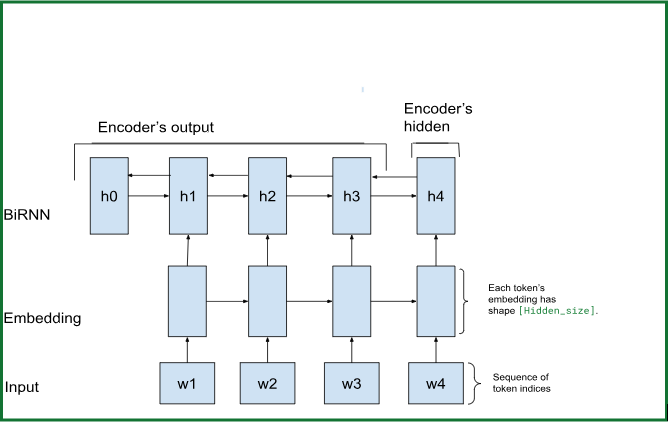

In [13]:
class Encoder(nn.Module):
    def __init__(self, Input_size, Hidden_size, p=0.1):#input_size: The size of the  vocabulary of input language.
        super(Encoder, self).__init__()
        self.Hidden_size = Hidden_size
        self.embedding = nn.Embedding(Input_size, Hidden_size) # Embedding layer to convert token indices into dense vectors of size Hidden_size
        self.rnn = nn.RNN(Hidden_size, Hidden_size // 2, batch_first=True, bidirectional=True)# Hidden_size//2 is used for the RNN hidden size because it is split between forward and backward
        self.dropout = nn.Dropout(p)

    def forward(self, Input):
      Input = Input.int()
      emb = self.dropout(self.embedding(Input))
      output, (hidden_forward, hidden_backward) = self.rnn(emb)
      hidden = torch.cat((hidden_forward, hidden_backward), dim=1).unsqueeze(0)
      return output, hidden

Luong Attention in a Decoder RNN:

1. Luong Attention: Requires the current decoder state to apply attention weights effectively.

2. Hidden State Calculation: The decoder’s hidden state is computed using the RNN.

3. Token Generation: In a decoder RNN with masked tokens, each time step generates the current token based on the output and hidden state from the previous time step.

4. Attention Application: Luong attention then uses the current decoder hidden state to compute attention weights and refine the generation of the current token.

 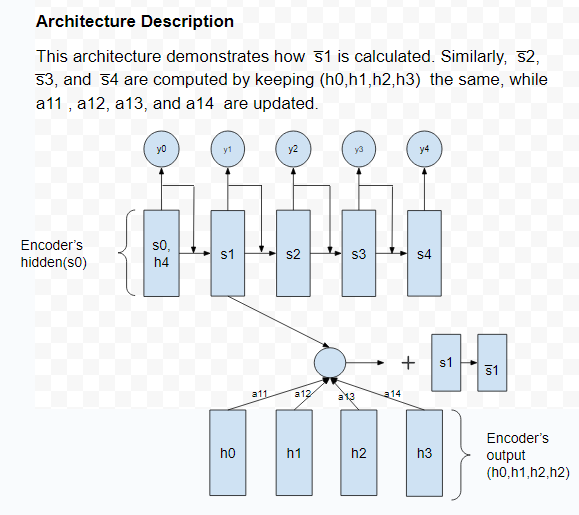






In [14]:
class LuongAttention(nn.Module):
    def __init__(self, Hidden_size):
        super(LuongAttention, self).__init__()
        self.va = nn.Linear(Hidden_size, Hidden_size)

    def forward(self, query, keys):
       # Calculate attention scores using dot product
        scores = torch.bmm(self.va(query), keys.transpose(1, 2)).squeeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights.unsqueeze(1), keys)

        return context
class AttnDecoder(nn.Module):
    def __init__(self ,Output_size,Hidden_size,dropout_p=0.1):#output_size  : The size of the vocabulary of target language.
        super(AttnDecoder,self).__init__()
        self.embedding = nn.Embedding(Output_size, Hidden_size)
        self.attention = LuongAttention(Hidden_size)# Reuse existing LuongAttention class
        self.rnn = nn.RNN(Hidden_size, Hidden_size , batch_first=True)
        self.out = nn.Linear(Hidden_size*2, Output_size)
        self.dropout = nn.Dropout(dropout_p)


    def forward(self, encoder_hidden ,encoder_output ):
        batch_size = encoder_hidden.size(1) # Get batch size from encoder hidden state
        decoder_input = torch.zeros(batch_size, 1, dtype=torch.long, device=encoder_hidden.device)
        decoder_hidden = encoder_hidden
        querrys = []# List to store decoder hidden states for attention calculation

         # Loop through maximum sequence length for decoding
        for i in range(MAX_LENGTH):

          # Step 1: Apply embedding, RNN, and store hidden state for attention
            decoder_output, decoder_hidden = self.forward_step1(decoder_input, decoder_hidden)
            permuted_hidden=decoder_hidden.permute(1,0,2)
            querrys.append(permuted_hidden)
            decoder_input = decoder_output.argmax(dim=-1)
        querrys = torch.cat(querrys, dim=1)
        decoder_outputs=[]# List to store decoder outputs

        for i in range(MAX_LENGTH):
            curr_decode_state=querrys[:,i] # Get current decoder hidden state
            decoder_output=self.forward_step2(curr_decode_state ,encoder_output)
            decoder_outputs.append(decoder_output)


        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs= F.log_softmax(decoder_outputs, dim=-1)


        return decoder_outputs

    def forward_step1(self, input, hidden):#input  : The decoder input , hidden  : The decoder hidden stat .
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)

        return output, hidden
    def forward_step2(self, query,key):# apply attention
        query=query.unsqueeze(1)
        context  = self.attention(query, key)
        output= torch.cat((query, context), dim=2)
        output = self.out(output)

        return output


# **Training the model:**


Prepare and Return DataLoader for Training


In [15]:
def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('hin', 'eng')
    n = len(pairs)  # Total number of sentence pairs

    # Initialize numpy arrays to store input and target IDs
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    # Convert sentences to indices and pad them to MAX_LENGTH
    for idx, (inp, tgt) in enumerate(train_set):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)

        # Append end-of-sequence token
        inp_ids.append(eos)
        tgt_ids.append(eos)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # Create TensorDataset from the input and target IDs
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))

    # Create a RandomSampler for the training data
    train_sampler = RandomSampler(train_data)

    # Create a DataLoader with the specified batch size
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    return input_lang, output_lang, train_dataloader

Sequence-to-Sequence Model Training with Epoch-wise Loss Tracking and Visualization:

In [16]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs = decoder(encoder_hidden, encoder_outputs)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.01, print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                          epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # Plot the training loss at the end of training
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(plot_losses) + 1), plot_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()


the model is trained for 20 epochs

In [17]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = Encoder(input_lang.Vocab_Len, hidden_size).to(device)
decoder = AttnDecoder(output_lang.Vocab_Len,hidden_size).to(device)


In [61]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)
encoder.load_state_dict(torch.load("/content/drive/MyDrive/encoder_path8"))
decoder.load_state_dict(torch.load("/content/drive/MyDrive/decoder_path8 (1)"))
#train(train_dataloader, encoder, decoder, 5, print_every=1, plot_every=1)

<All keys matched successfully>

# **Model Evaluation and Metrics:**

Function to Evaluate and Decode Text Using a Trained Encoder-Decoder Model

In [20]:
def evaluate(encoder, decoder, Text, input_lang, output_lang):
    # Disable gradient calculation for evaluation mode
    with torch.no_grad():
        # Convert the input sentence into a tensor of indices
        input_tensor = tensorFromSentence(input_lang, Text)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs = decoder(encoder_hidden, encoder_outputs)

        # Get the top predicted word index for each step from the decoder output
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()
        decoded_words = []

        for idx in decoded_ids:
            if idx.item() == eos:  # If the end-of-sequence token is encountered, stop decoding
                decoded_words.append('<eos>')
                break
            decoded_words.append(output_lang.Index_To_Word[idx.item()])

    return decoded_words

Calculate BLEU and METEOR Scores for Model Output

In [73]:
import sacrebleu

def BLUE_SCORE(encoder, decoder, data):
    references = []
    hypotheses = []


    for input_sentence, target_sentence in data:

        output_words = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        # Collect the target and output sentences
        references.append([target_sentence])  # SacreBLEU expects a list of lists for references
        hypotheses.append(output_sentence)    # A list of hypothesis sentences

    # Calculate BLEU score for all sentences using SacreBLEU
    bleu_score = sacrebleu.corpus_bleu(hypotheses, references).score

    return bleu_score

In [24]:
nltk.download('wordnet')
def METEOR_SCORE(encoder, decoder, data ):
    meteor_scores = []
    for input_sentence, target_sentence in data:

        output_words = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        target_tokens = target_sentence.split()
        output_tokens = output_sentence.split()

        score = meteor_score([target_tokens], output_tokens)
        meteor_scores.append(score)
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)

    return average_meteor_score



[nltk_data] Downloading package wordnet to /root/nltk_data...


In [77]:
# Calculate BLEU and METEOR scores for sample datasets
calculated_bleu_score = BLUE_SCORE(encoder, decoder, val_set  )
calculated_meteor_score = METEOR_SCORE(encoder, decoder, val_set  )

print("blue score for validation set:" , calculated_bleu_score )
print(f"METEOR Score for validation set: {calculated_meteor_score:.4f}")

blue score for validation set: 10.682175159905853
METEOR Score for validation set: 0.2217



Evaluate Model Predictions on Validation Set

In [78]:
def evaluate_Val(encoder, decoder, n=5):
    for i in range(n):

        pair = random.choice(val_set[:100])
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0], input_lang, output_lang)

        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [96]:
encoder.eval()
decoder.eval()
evaluate_Val(encoder, decoder)

> नोकझोक
= irony
< satire <eos>

> इबेरिया प्रायद्वीप
= iberian peninsula
< iberian peninsula peninsula peninsula <eos>

> हां  स्थानीय लोग न तो भावुक होते हैं
= well indigenous people are neither sentimental
< you s you are <eos>

> अंतर्मुखता
= introversion
< interiorly <eos>

> अग्नि पंचम
= agni v
< agni v a to <eos>

